# Machine Learning - Practical 4 - Deep Learning VS Trees


Names: {YOUR NAMES}  
Summer Term 2023   
Due Date: Tuesday, June 13, 2pm

In this practical we are going to use a tabular dataset. We will test two different approaches - forests and neural networks and compare performance. We are also going to learn how to make trees interpretable.

To prepare this tutorial we used [this paper](https://arxiv.org/pdf/2207.08815.pdf) with its [repository](https://github.com/LeoGrin/tabular-benchmark).

For explained variance in trees, you can read more [here](https://scikit-learn.org/0.15/auto_examples/ensemble/plot_gradient_boosting_regression.html#example-ensemble-plot-gradient-boosting-regression-py).


In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score

from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
torch.manual_seed(42) # Set manual seed

In [2]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cuda:0


## Load, clean and split the tabular dataset

We use the preprocessing pipeline from [Grinsztajn, 2022](https://arxiv.org/pdf/2207.08815.pdf).

**No missing data**    

Remove all rows containing at least one missing entry.    

*In practice people often do not remove rows with missing values but try to fill missing values in a column with the mean or median values for numerical data and mode or median values for categorical data. Sometimes even simple prediction models are used to fill in the gaps but we will remove rows or columns with missing values for the sake of simplicity*

**Balanced classes**   

For classification, the target is binarised if there are multiple classes, by taking the two most numerous classes, and we keep half of samples in each class.

**Low cardinality categorical features**   

Remove categorical features with more than 20 items. 

**High cardinality numerical features**   

Remove numerical features with less than 10 unique values. Convert numerical features with 2 unique values to categorical.

**Data description:**  
Data reported to the police about the circumstances of personal injury road accidents in Great Britain from 1979. This version includes data up to 2015. We will try to predict the sex of the driver based on the data provided.

In [3]:
## In case you have any issues with loading the pickle file
## check that your pandas version is 1.4.1
## or just simply run:
## pip install pandas==1.4.1

with open('/kaggle/input/adopted-road-safety/adopted_road_safety.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [4]:
target_column = 'Sex_of_Driver'
test_size = 0.2
random_state = 42

In [5]:
def remove_nans(df):
    '''
    this fucntion removes rows with nans 
    '''
    df = df.dropna()
    return df


def numerical_to_categorical(df, n=2, ignore=[target_column]):
    '''
    change the type of the column to categorical 
    if it has <= n unique values
    '''
    #get columns with <=2
    cols_with_n = df.nunique()[df.nunique() <= n].index
    #ignore target column from this list
    cols_with_n = [x for x in cols_with_n if x not in ignore]
    #convert these columns to category
    df = df.copy()
    df[cols_with_n] = df[cols_with_n].astype('category')
    return df


def remove_columns_by_n(df, n=10, condition=np.number, direction='less', 
                        ignore=[target_column]):
    '''
   
    Remove columns with more or less than n unique values. 
    Usually it makes sense to apply this function to columns with categorical values (see below where it is called).
    With the default values we remove all numerical columns which have less than 10 unique values (except for the target_column).
    '''
    #only select cols with specified dtype
    cols = df.select_dtypes(include=[condition]).columns
    #this columns make up the df_new
    df_new = df[cols]
    #apply condition to df_new
    if direction=='less':
        cols_ = df_new.nunique()[df_new.nunique() < n].index
    elif direction=='more':
        cols_ = df_new.nunique()[df_new.nunique() > n].index
    #for the cols_, check if target column is present, and ignore this
    cols_ = [x for x in cols_ if x not in ignore]
    #drop these cols_ in the final dataframe
    df = df.drop(cols_, axis=1)
    return df

In [6]:
df = dataset
df = remove_nans(df)
df = numerical_to_categorical(df, n=2, ignore=[target_column])
df = remove_columns_by_n(df, n=10, condition=np.number, direction='less', 
                         ignore=[target_column])
df = remove_columns_by_n(df, n=40, condition='category', direction='more', 
                         ignore=[target_column])
assert not df.isna().any().any(), 'There are still nans in the dataframe'

In [7]:
# TODO : make train-test split from the dataframe using the parameters above
# expected results variable names - train_X, test_X, train_y, test_y

X = df.drop(target_column, axis=1)
Y = df[target_column]

In [8]:
print(X.shape)
print(Y.shape)

(96326, 28)
(96326,)


In [9]:
X.select_dtypes(include=['category']).columns

Index(['Was_Vehicle_Left_Hand_Drive?', 'Urban_or_Rural_Area',
       'Sex_of_Casualty'],
      dtype='object')

In [10]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

features_to_encode = ['Was_Vehicle_Left_Hand_Drive?', 'Urban_or_Rural_Area', 'Sex_of_Casualty']
for feature in features_to_encode:
    X = encode_and_bind(X, feature)

In [11]:
X.dtypes

Vehicle_Type                        float64
Vehicle_Manoeuvre                   float64
Vehicle_Location-Restricted_Lane    float64
Hit_Object_in_Carriageway           float64
Hit_Object_off_Carriageway          float64
Age_of_Driver                       float64
Age_Band_of_Driver                  float64
Engine_Capacity_(CC)                float64
Age_of_Vehicle                      float64
Location_Easting_OSGR               float64
Location_Northing_OSGR              float64
Longitude                           float64
Latitude                            float64
Police_Force                        float64
Number_of_Casualties                float64
Local_Authority_(District)          float64
1st_Road_Number                     float64
2nd_Road_Number                     float64
Casualty_Reference                    int64
Age_of_Casualty                     float64
Age_Band_of_Casualty                float64
Pedestrian_Location                 float64
Pedestrian_Movement             

In [12]:
train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=test_size, random_state=random_state)

In [13]:
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(77060, 31)
(19266, 31)
(77060,)
(19266,)


**TODO :**  

* Did you split the dataset in a stratified manner or not? Why?
* How did the dataset dimensions change after preprocessing?
* How many unique values are in the response variable? 

## Task 1: Create a GradientBoostingClassifier

In [14]:
%%time
## TODO : define the GradientBoostingClassifier, 
## train it on the train set and predict on the test set
clf = GradientBoostingClassifier().fit(train_X, train_y)
y_pred = clf.predict(test_X)

CPU times: user 1min 8s, sys: 48 ms, total: 1min 8s
Wall time: 1min 8s


In [15]:
y_pred

array(['1.0', '1.0', '1.0', ..., '2.0', '1.0', '1.0'], dtype=object)

In [16]:
## TODO : print  accuracy, precision, recall
## Hint : use functions from sklearn metrics
print("Accuracy score: {0:.3f}".format(accuracy_score(test_y, y_pred)))
print("Recall score: {0:.3f}".format(recall_score(test_y, y_pred, average='weighted')))
print("Precision score: {0:.3f}".format(precision_score(test_y, y_pred, average='weighted')))

Accuracy score: 0.774
Recall score: 0.774
Precision score: 0.769


In [17]:
## TODO : Write a function which iterates over trees_amount, 
## train a classifier with a specified amount of trees and print accuracy, precision, and recall.
## Note: the calculations may take several minutes (depending on the computer efficiency).

def trees_amount_exploration(train_X, train_y, test_X, test_y, trees_amount=[1, 20, 50, 100]):
    for n_tree in trees_amount:
        clf = GradientBoostingClassifier(n_estimators=n_tree)
        clf.fit(train_X, train_y)
        y_pred = clf.predict(test_X)
        
        print("Trees amount: ", n_tree)
        print("Accuracy score: {0:.3f}".format(accuracy_score(test_y, y_pred)))
        print("Recall score: {0:.3f}".format(recall_score(test_y, y_pred, average='weighted')))
        print("Precision score: {0:.3f}".format(precision_score(test_y, y_pred, average='weighted')))


In [18]:
%%time
trees_amount_exploration(train_X, train_y, test_X, test_y)

Trees amount:  1
Accuracy score: 0.652
Recall score: 0.652
Precision score: 0.425


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Trees amount:  20
Accuracy score: 0.747
Recall score: 0.747
Precision score: 0.740
Trees amount:  50
Accuracy score: 0.766
Recall score: 0.766
Precision score: 0.760
Trees amount:  100
Accuracy score: 0.774
Recall score: 0.774
Precision score: 0.769
CPU times: user 2min, sys: 79.7 ms, total: 2min
Wall time: 2min


In [19]:
## TODO : Write a function which iterates over the learning rate, 
## train a classifier with a specified amount of trees and print accuracy, precision, and recall.
## Note: the calculations may take several minutes (depending on the computer efficiency).

def learning_rate_exploration(train_X, train_y, test_X, test_y, learning_rates = [0.1, 0.2, 0.3, 0.4, 0.5], trees_amount=100):
    for lr in learning_rates:
        clf = GradientBoostingClassifier(n_estimators=trees_amount, learning_rate=lr)
        clf.fit(train_X, train_y)
        y_pred = clf.predict(test_X)
        
        print("Learning rate: ", lr)
        print("Accuracy score: {0:.3f}".format(accuracy_score(test_y, y_pred)))
        print("Recall score: {0:.3f}".format(recall_score(test_y, y_pred, average='weighted')))
        print("Precision score: {0:.3f}".format(precision_score(test_y, y_pred, average='weighted')))

In [20]:
%%time
learning_rate_exploration(train_X, train_y, test_X, test_y)

Learning rate:  0.1
Accuracy score: 0.774
Recall score: 0.774
Precision score: 0.769
Learning rate:  0.2
Accuracy score: 0.781
Recall score: 0.781
Precision score: 0.776
Learning rate:  0.3
Accuracy score: 0.775
Recall score: 0.775
Precision score: 0.771
Learning rate:  0.4
Accuracy score: 0.778
Recall score: 0.778
Precision score: 0.774
Learning rate:  0.5
Accuracy score: 0.783
Recall score: 0.783
Precision score: 0.779
CPU times: user 5min 47s, sys: 177 ms, total: 5min 47s
Wall time: 5min 48s


In [21]:
## TODO : Write a function which iterates over different depths, 
## train a classifier with a specified depth and print accuracy, precision, and recall
## Set trees_amount= 50 to make the calculations faster
## Note: the calculations may take several minutes (depending on the computer efficiency).

def max_depth_exploration(train_X, train_y, test_X, test_y, depths=[1,2,3,5]):
    for depth in depths:
        clf = GradientBoostingClassifier(n_estimators=50, max_depth = depth)
        clf.fit(train_X, train_y)
        y_pred = clf.predict(test_X)
        
        print("Depth: ", depth)
        print("Accuracy score: {0:.3f}".format(accuracy_score(test_y, y_pred)))
        print("Recall score: {0:.3f}".format(recall_score(test_y, y_pred, average='weighted')))
        print("Precision score: {0:.3f}".format(precision_score(test_y, y_pred, average='weighted')))

In [22]:
max_depth_exploration(train_X, train_y, test_X, test_y)

Depth:  1
Accuracy score: 0.747
Recall score: 0.747


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision score: 0.738
Depth:  2
Accuracy score: 0.749
Recall score: 0.749
Precision score: 0.742
Depth:  3
Accuracy score: 0.766
Recall score: 0.766
Precision score: 0.760
Depth:  5
Accuracy score: 0.784
Recall score: 0.784
Precision score: 0.780


**TODO :**   

* How does the max_depth parameter influence the results? 
* How does the learning rate influence the results?
* How does the number of trees in the ensemble influence the results?
* Try to improve the accuracy by combining different max_depth, learning rate and number of trees. How well does your best model perform?

In [23]:
## TODO -  sklearn trees have the attribute feature_importances_
## make a plot, to show relative importance (maximum is 1) of your classifier and
## order features from most relevant feature to the least relevant in the plot

def plot_explained_variance(clf, X):
    feature_importance = clf.feature_importances_
    #returns the indices that would sort an array
    sorted_idx = np.argsort(feature_importance)

    #plotting
    featfig = plt.figure()
    featax = featfig.add_subplot(1, 1, 1)
    pos = np.arange(sorted_idx.shape[0]) + .5
    featax.barh(pos, feature_importance[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
    
    plt.title('Feature Importance')
    plt.ylabel('Features')

    plt.tight_layout()   
    plt.show()

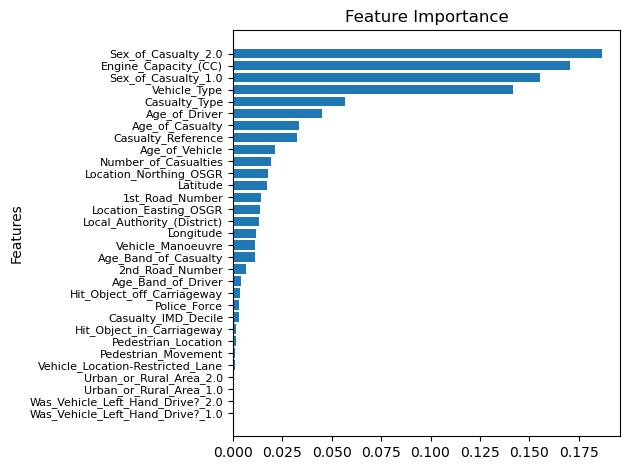

CPU times: user 56.3 s, sys: 209 ms, total: 56.5 s
Wall time: 56.5 s


In [24]:
%%time
## TODO : display the plot
clf = GradientBoostingClassifier(n_estimators=50, learning_rate = 0.5, max_depth = 5).fit(train_X, train_y)
plot_explained_variance(clf, X)

**TODO :** Interpret the plot.

**TODO (optional):** Try to remove the least-important features and see what happens. Does to quality improve or degrade? Why? 

## Prepare for deep learning
### Add all the necessary training functions 
*You can reuse them from previous practical exercises*

In [25]:
## TODO write a function that calculates the accuracy
## Hint - you can use yours from practical 3 

def accuracy(correct, total): 
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    return correct/total

In [62]:
## TODO : Define a train and validation functions here
## Hint - you can use yours from practical 3 

def train(dataloader, optimizer, model, loss_fn, device):
    """ method to train the model """
    model_in_gpu = model.to(device)
    model_in_gpu.train()
    losses_train = []
    correct = 0
    total = 0
    for i, (x, y) in enumerate(dataloader):
            # delete the gradients from last training iteration
            optimizer.zero_grad()
        

            # Forward pass: get predictions
            y_pred = model_in_gpu(x.to(device))

            # Compute loss
            loss = loss_fn(y_pred,y.to(device))
            losses_train.append(loss)
            
            #calculate accuracy
            correct += torch.sum((torch.argmax(y_pred,1) == y.to(device)))
            #add the batchsize to the total
            total += x.shape[0]

            # Backward pass -> calculate gradients, update weights
            loss.backward()
            optimizer.step()
        
    return (np.mean(losses_train), accuracy(correct.cpu().detach().numpy(),total))


def validate(dataloader, model, loss_fn, device):
    """ method to compute the metrics on the validation set """
    # TODO: write a validation function that calculates the loss and accuracy on the validation set
    # you can also combine it with the training function:
    model_in_gpu = model.to(device)
    model_in_gpu.eval()
    loss_val = []
    correct = 0
    total = 0
    for i, (x, y) in enumerate(dataloader):
        # Forward pass: get predictions
        with torch.no_grad():
            y_pred = model_in_gpu(x.to(device))
        

        #torch.argmax(ypred,1) calculates predicted class for each sample in batch
        correct += torch.sum((torch.argmax(y_pred,1) == y.to(device)))
        #add the batchsize to the total
        total += x.shape[0]
            
        # Compute loss
        loss = loss_fn(y_pred,y.to(device))
        loss_val.append(loss)

            
    return (np.mean(loss_val), accuracy(correct.cpu().detach().numpy(),total))

In [63]:
#TODO write a run_training function that 
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
## Hint - you can use yours from practical 3 
from tqdm import trange


def run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader):
    """ method to run the training procedure """
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    for epoch in trange(num_epochs):
        train_loss, train_acc = train(train_dataloader, optimizer, model, loss_fn, device)
        val_loss, val_acc = validate(val_dataloader, model, loss_fn, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    
    return (np.array(train_losses),np.array(train_accs),np.array(val_losses),np.array(val_accs))

In [64]:
# TODO write a plot function 
## Hint - you can use yours from practical 2 or 3 
def plotting_func(train_metric, val_metric, metric):
    epochs = np.arange(1,num_epochs +1)
    plt.plot(epochs,train_metric, color = "tab:blue", ls = "--", marker = 'o', label = "Training")
    plt.plot(epochs,val_metric, color = "tab:orange", ls = "--",marker = 'o', label = "Validation")
    plt.xlabel("Epoch")
    plt.ylabel("{}".format(metric))
    plt.title("Epoch vs. {}".format(metric))
    plt.legend()
    plt.show()

### Convert a pandas dataframe to a PyTorch dataset

In [65]:
## TODO : Define the dataset, apply normalization in the getitem method
## Hint : you can use/adapt your code from practical 2
class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, df_x, df_y, mean=None, std=None, normalise=True):
        '''
        TODO: save params to self attributes, 
        x is data without target column
        y is target column
        transform df to_numpy
        ''' 
        self.x = df_x
        self.y = df_y
        self.mean = np.array(mean)
        self.std = np.array(std)
        self.normalise = normalise
    
    
    def __len__(self):
        # TODO: return the length of the whole dataset
        return len(self.x)
    
    def __getitem__(self, index):
        ## TODO: return X, y by index, normalized if needed
        data = self.x[index]
        if self.normalise and self.mean is not None and self.std is not None:
            data = (data - self.mean) / self.std
        return data, self.y[index]
    

In [66]:
#change Y to datatype integer, and should start from 0
mappings = {
   '1.0': 0,
   '2.0': 1,
   '3.0': 2
}
df[target_column] = df[target_column].apply(lambda x: mappings[x])
df[target_column] = pd.Categorical(df[target_column])
# df[target_column] = df[target_column].cat.codes
df[target_column]

KeyError: 0

In [68]:
Y

2         1.0
6         1.0
7         1.0
8         1.0
12        2.0
         ... 
328127    2.0
328128    1.0
328129    1.0
328130    2.0
328131    2.0
Name: Sex_of_Driver, Length: 96326, dtype: category
Categories (3, object): ['1.0', '2.0', '3.0']

In [67]:
#convert all X to float64, not sure what is meant by all numerical
cols_list = X.columns
X_new = X[cols_list].astype('float64')
X_new.dtypes

Vehicle_Type                        float64
Vehicle_Manoeuvre                   float64
Vehicle_Location-Restricted_Lane    float64
Hit_Object_in_Carriageway           float64
Hit_Object_off_Carriageway          float64
Age_of_Driver                       float64
Age_Band_of_Driver                  float64
Engine_Capacity_(CC)                float64
Age_of_Vehicle                      float64
Location_Easting_OSGR               float64
Location_Northing_OSGR              float64
Longitude                           float64
Latitude                            float64
Police_Force                        float64
Number_of_Casualties                float64
Local_Authority_(District)          float64
1st_Road_Number                     float64
2nd_Road_Number                     float64
Casualty_Reference                  float64
Age_of_Casualty                     float64
Age_Band_of_Casualty                float64
Pedestrian_Location                 float64
Pedestrian_Movement             

In [69]:
Y_new = df[target_column]
train_X, test_X, train_y, test_y = train_test_split(X.values, Y_new.values, test_size=test_size, random_state=random_state)

In [70]:
test_y.unique()

[0, 1, 2]
Categories (3, int64): [0, 1, 2]

In [71]:
train_y.unique()

[0, 1, 2]
Categories (3, int64): [0, 1, 2]

In [72]:
train_X = torch.FloatTensor(train_X)
test_X = torch.FloatTensor(test_X)
train_y = torch.LongTensor(train_y)
test_y = torch.LongTensor(test_y)

In [73]:
## TODO : calculate mean and std for the train set
## Hint : be careful with categorical values. Convert them them to numerical 
## Hint : the response variable should be of datatype integer
mean_train = train_X.mean(axis=0) #calculates mean for one column so for each feature
std_train = train_X.std(axis=0) #calculates std for each column

In [74]:
# TODO : define new datasets with mean, std and normalise=True
# be careful with the labels, they should start from 0!
conductor_train = TabularDataset(train_X, train_y, mean = mean_train, std = std_train ,normalise=True)

mean_test = test_X.mean(axis = 0)
std_test = test_X.std(axis =0)

conductor_test = TabularDataset(test_X, test_y,mean = mean_test, std = std_test ,normalise=True)

## TODO : define dataloaders, with specified batch size and shuffled
batch_size = 256
train_dataloader = torch.utils.data.DataLoader(conductor_train,batch_size,shuffle = True)
test_dataloader = torch.utils.data.DataLoader(conductor_test,batch_size,shuffle = True)

In [75]:
#We will dispay the dimensions of x and y for the first batch
for i in train_dataloader.batch_sampler:
    batch_1_x = train_dataloader.dataset.x[i]  #iloc can get rows for list of indexes i 
    print(f"Dimensions of x for first batch:{batch_1_x.shape}")
    batch_1_y = train_dataloader.dataset.y[i]
    print(f"Dimension of y for first batch:{batch_1_y.shape}")
    break

Dimensions of x for first batch:torch.Size([256, 31])
Dimension of y for first batch:(256,)


## Logistic regression

In [76]:
class LR(torch.nn.Module):
    """
    The logistic regression model inherits from torch.nn.Module 
    which is the base class for all neural network modules.
    """
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(LR, self).__init__()
        # TODO define linear layer for the model
        self.layer1 = torch.nn.Linear(input_dim, output_dim)
        

    def forward(self, x):
        """ Defines the computation performed at every call. """
        # What are the dimensions of your input layer?
        x = x.to(torch.float32)
        # TODO run the data through the layer
        outputs = self.layer1(x)
        
        return outputs

In [77]:
## TODO define model, loss and optimisers
## don't forget to move everything for the correct devices
## 
lr=0.001
input_dim = 31    #input dim is number of pixel values for each channel
output_dim = 1
logistic_regression = LR(input_dim, output_dim)
optimizer = torch.optim.Adam(logistic_regression.parameters(), lr=lr)
loss_fn = torch.nn.CrossEntropyLoss()

In [78]:
## TODO train the network
num_epochs = 30
#use test_dataloader as validation_dataloader
train_losses,train_accs,val_losses,val_accs=run_training(logistic_regression, optimizer, loss_fn, device, num_epochs, train_dataloader, test_dataloader)

  0%|          | 0/30 [00:00<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
## todo - plot losses and accuracies
plot('Epoch vs. Loss', 'Loss', train_losses_lr, val_losses_lr)

In [ ]:
plot('Epoch vs. Accuracy', 'Accuracy', train_accs_lr, val_accs_lr)


## Create a simple MLP

As the default tree has 3 layers, let's make a MLP with 3 linear layers and ReLU.
Please notice that making convolutions on tabular data does not make much sense even though it is technically possible.   

**TODO :** Explain why making convolutions on tabular data does not make much sense. Why do we use an MLP, not a CNN from the previous homework?

In [ ]:
class TabularNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(TabularNetwork, self).__init__()
        self.network = nn.Sequential(
            # TODO : define 3 linear layer with sizes 
            # input_dim -> input_dim // 2 -> output_dim
            # using ReLU as nonlinearity
            
                      torch.nn.Linear(input_dim,input_dim//2),
                      torch.nn.ReLU(),
                      torch.nn.Linear(input_dim//2,output_dim),
                    )
            
      

    def forward(self, x):
        """ Defines the computation performed at every call. """
        outputs = self.network(x)
        return outputs

In [ ]:
## TODO : define model, optimiser, cross entropy loss,
## put model to the device, and train mode
## you can optionally apply regularisation between 0.0005 and 0.005 
lr=0.001
mlp_model = TabularNetwork(input_dim, output_dim)
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.001)
loss_fn_mlp = nn.CrossEntropyLoss()

In [ ]:
## TODO : Train model
num_epochs = 50
train_losses_mlp,train_accs_mlp,val_losses_mlp,val_accs_mlp=run_training(mlp_model, optimizer_mlp, loss_fn_mlp, device, num_epochs, train_dataloader, test_dataloader)

In [ ]:
# TODO plot losses
plot(train_losses, val_losses, 'Loss')

In [ ]:
# TODO plot accuracies
plot(train_accs, val_accs, 'Accuracy')

**TODO:** Did your network perform better or worse than the GradientBoostingClassifier on this dataset? Why? 


## Bonus tasks (optional)
* Try to use SGD instead of Adam as optimiser. What do you notice?
Here are different opinions on this topic:
  * https://codeahoy.com/questions/ds-interview/33/#:~:text=Adam%20tends%20to%20converge%20faster,converges%20to%20more%20optimal%20solutions.
  * https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/ 
  * https://datascience.stackexchange.com/questions/30344/why-not-always-use-the-adam-optimization-technique

* Try to make your MLP twice deeper. What do you notice? Why?

## Advanced topic to read about:
**Tools which may be helpful for data exploration:**
* df.describe() - returns some basic statistics for your dataset - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html
* ydata-profiling (previous pandas-profiling) - generates interactive data exploration report: basic statistics, nans, correlations between different features - https://github.com/ydataai/ydata-profiling

**Tree libraries**
* XGBoost - XGBoost stands for “Extreme Gradient Boosting”, where the term “Gradient Boosting” originates from the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman. https://xgboost.readthedocs.io/en/stable/tutorials/model.html
* LightGBM - industrial library for XGBoost from Miscrosoft. LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient. https://lightgbm.readthedocs.io/en/v3.3.2/